In [1]:
import torchvision
from torchvision import io,transforms,models
import os
from torch.utils.data import DataLoader,Dataset,random_split,ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score,f1_score
import torch.nn.functional as F
from torch import optim
import torch
import random
import re
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)
random.seed(0)

<b> Original Approach </b><br><br>
Previously, we trained our model at the slide level (level 2 of SVS) by resizing image to 224x224 dimension.  At this resolution, the program can generalize based on color patterns (e.g. plaques appear brown).  However, this approach lacks finer contextual information.<br><br>
<b> Motivation </b><br>
How can we quantify plaque in a more meaningful way?<br>
<b> Proposed Method</b>: Weak Supervision<br>
We will explore weak supervision using the following strategy:

        1) Data Preparation:
            - Utilize level 2 of SVS file (level 1 offers the highest resolution, but level 2 significantly reduces computational demands while maintaining sufficient detail).
            - Divide each slide into 224x224 pixel patches.

        2) Label Assignment:
            - Assign slide-level label to all patches from the corresponding sample.
            - Note: This introduces label noise, as not all patches in AD samples contain plaque.
        3) Edge Effects:
            - We will ignore edge effects for now, despite the presence of "plaque" artifacts at the image borders in both AD and control samples.

<b> Model Training and Inference </b><br>

    - We will train a  CNN using ResNet 18 (transfer learning) and evaluate on a completely different test set:
    - The test set comprises  patches from samples not seen in the training set. 
     
         1)29966 (AD) -17.2 Weeks
         2)30118 (AD) - 11.0 Weeks
         3) 30037 (AD) - 14.3 Weeks
         4) 30041 (Control) -14.5 Weeks
         5) 29983 (Control) -17.0 Weeks
         6)30105 (Control) - 11.4 Weeks
         
    - Once training is complete, we will run inference on the combined dataset (train+test)
    - For each sample, caculate the percentage of patches predicted to contain plaque.
 <b>Hypothesis</b>: <br>
 We expect a difference in plaque burden across different age groups.

<br>
<b> Example of how we can divide an image patch</b>. 
Each patch is a 224x224 image. <br>
<img src="image_patch.png"></image>

The current working directory.

In [3]:
os.getcwd()

'/vf/users/banskotan2/Projects/Deep_Learning'

Let's create a tensor. ImageFolder returns image in PIL format. We need to therefore convert it to torch Tensor and normalize images. 

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

])

We will use torchvision's ImageFolder to load the data.  The Train and Test folders have two subfolders: AD and Control.  
Torchvision assigns labels in alphabetical order.  Therefore, 0 is AD, while 1 is Control.

In [5]:
train_dataset=torchvision.datasets.ImageFolder(root="/data/banskotan2/Projects/Deep_Learning/5XFAD/patches/Train/",transform=transform)
test_dataset=torchvision.datasets.ImageFolder(root="/data/banskotan2/Projects/Deep_Learning/5XFAD/patches/Test/",transform=transform)
train_dataset_no_norm=torchvision.datasets.ImageFolder(root="/data/banskotan2/Projects/Deep_Learning/5XFAD/patches/Train/")

Let's create some DataLoaders as well.

In [6]:
train_data=DataLoader(train_dataset,batch_size=128,shuffle=True)
test_data=DataLoader(test_dataset,batch_size=128,shuffle=True)

Let's look at what the labels look like.  It will be a list of 1's' and zeros.

In [7]:
for images,labels in train_data:
    print(images.size(),labels)
    break

torch.Size([128, 3, 224, 224]) tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 1, 0, 1])


In [8]:
print(f"Training Dataset: {len(train_dataset)}, Testing Dataset {len(test_dataset)}")

Training Dataset: 5650, Testing Dataset 1806


The training dataset consists of 5,650 total images(from 19 samples), while the testing dataset consists of 1,806 images (from 6 samples)

Create a function to display images.

In [9]:
def run_image(data,l=5,w=5,start=0,sz=(18,10),dpi=200):
    total_images=l*w
    fig,ax=plt.subplots(l,w,figsize=sz,dpi=dpi)
    end=start+l*w
    for i,j in enumerate(range(start,end)):
        #print(i)
        image,label=data[j]
        if i>=l*w:
            break
        row=i//w
        col=i%w
        ax[row,col].imshow(image)
        cond="AD" if label==0 else "Control"
        title_for_plot=cond
        ax[row,col].set_title(title_for_plot)
    plt.tight_layout()
    plt.show()

The datasets are shuffled. I got these images after a few trial and errors.

This is <b>AD</b> You can see the plaque clearly.

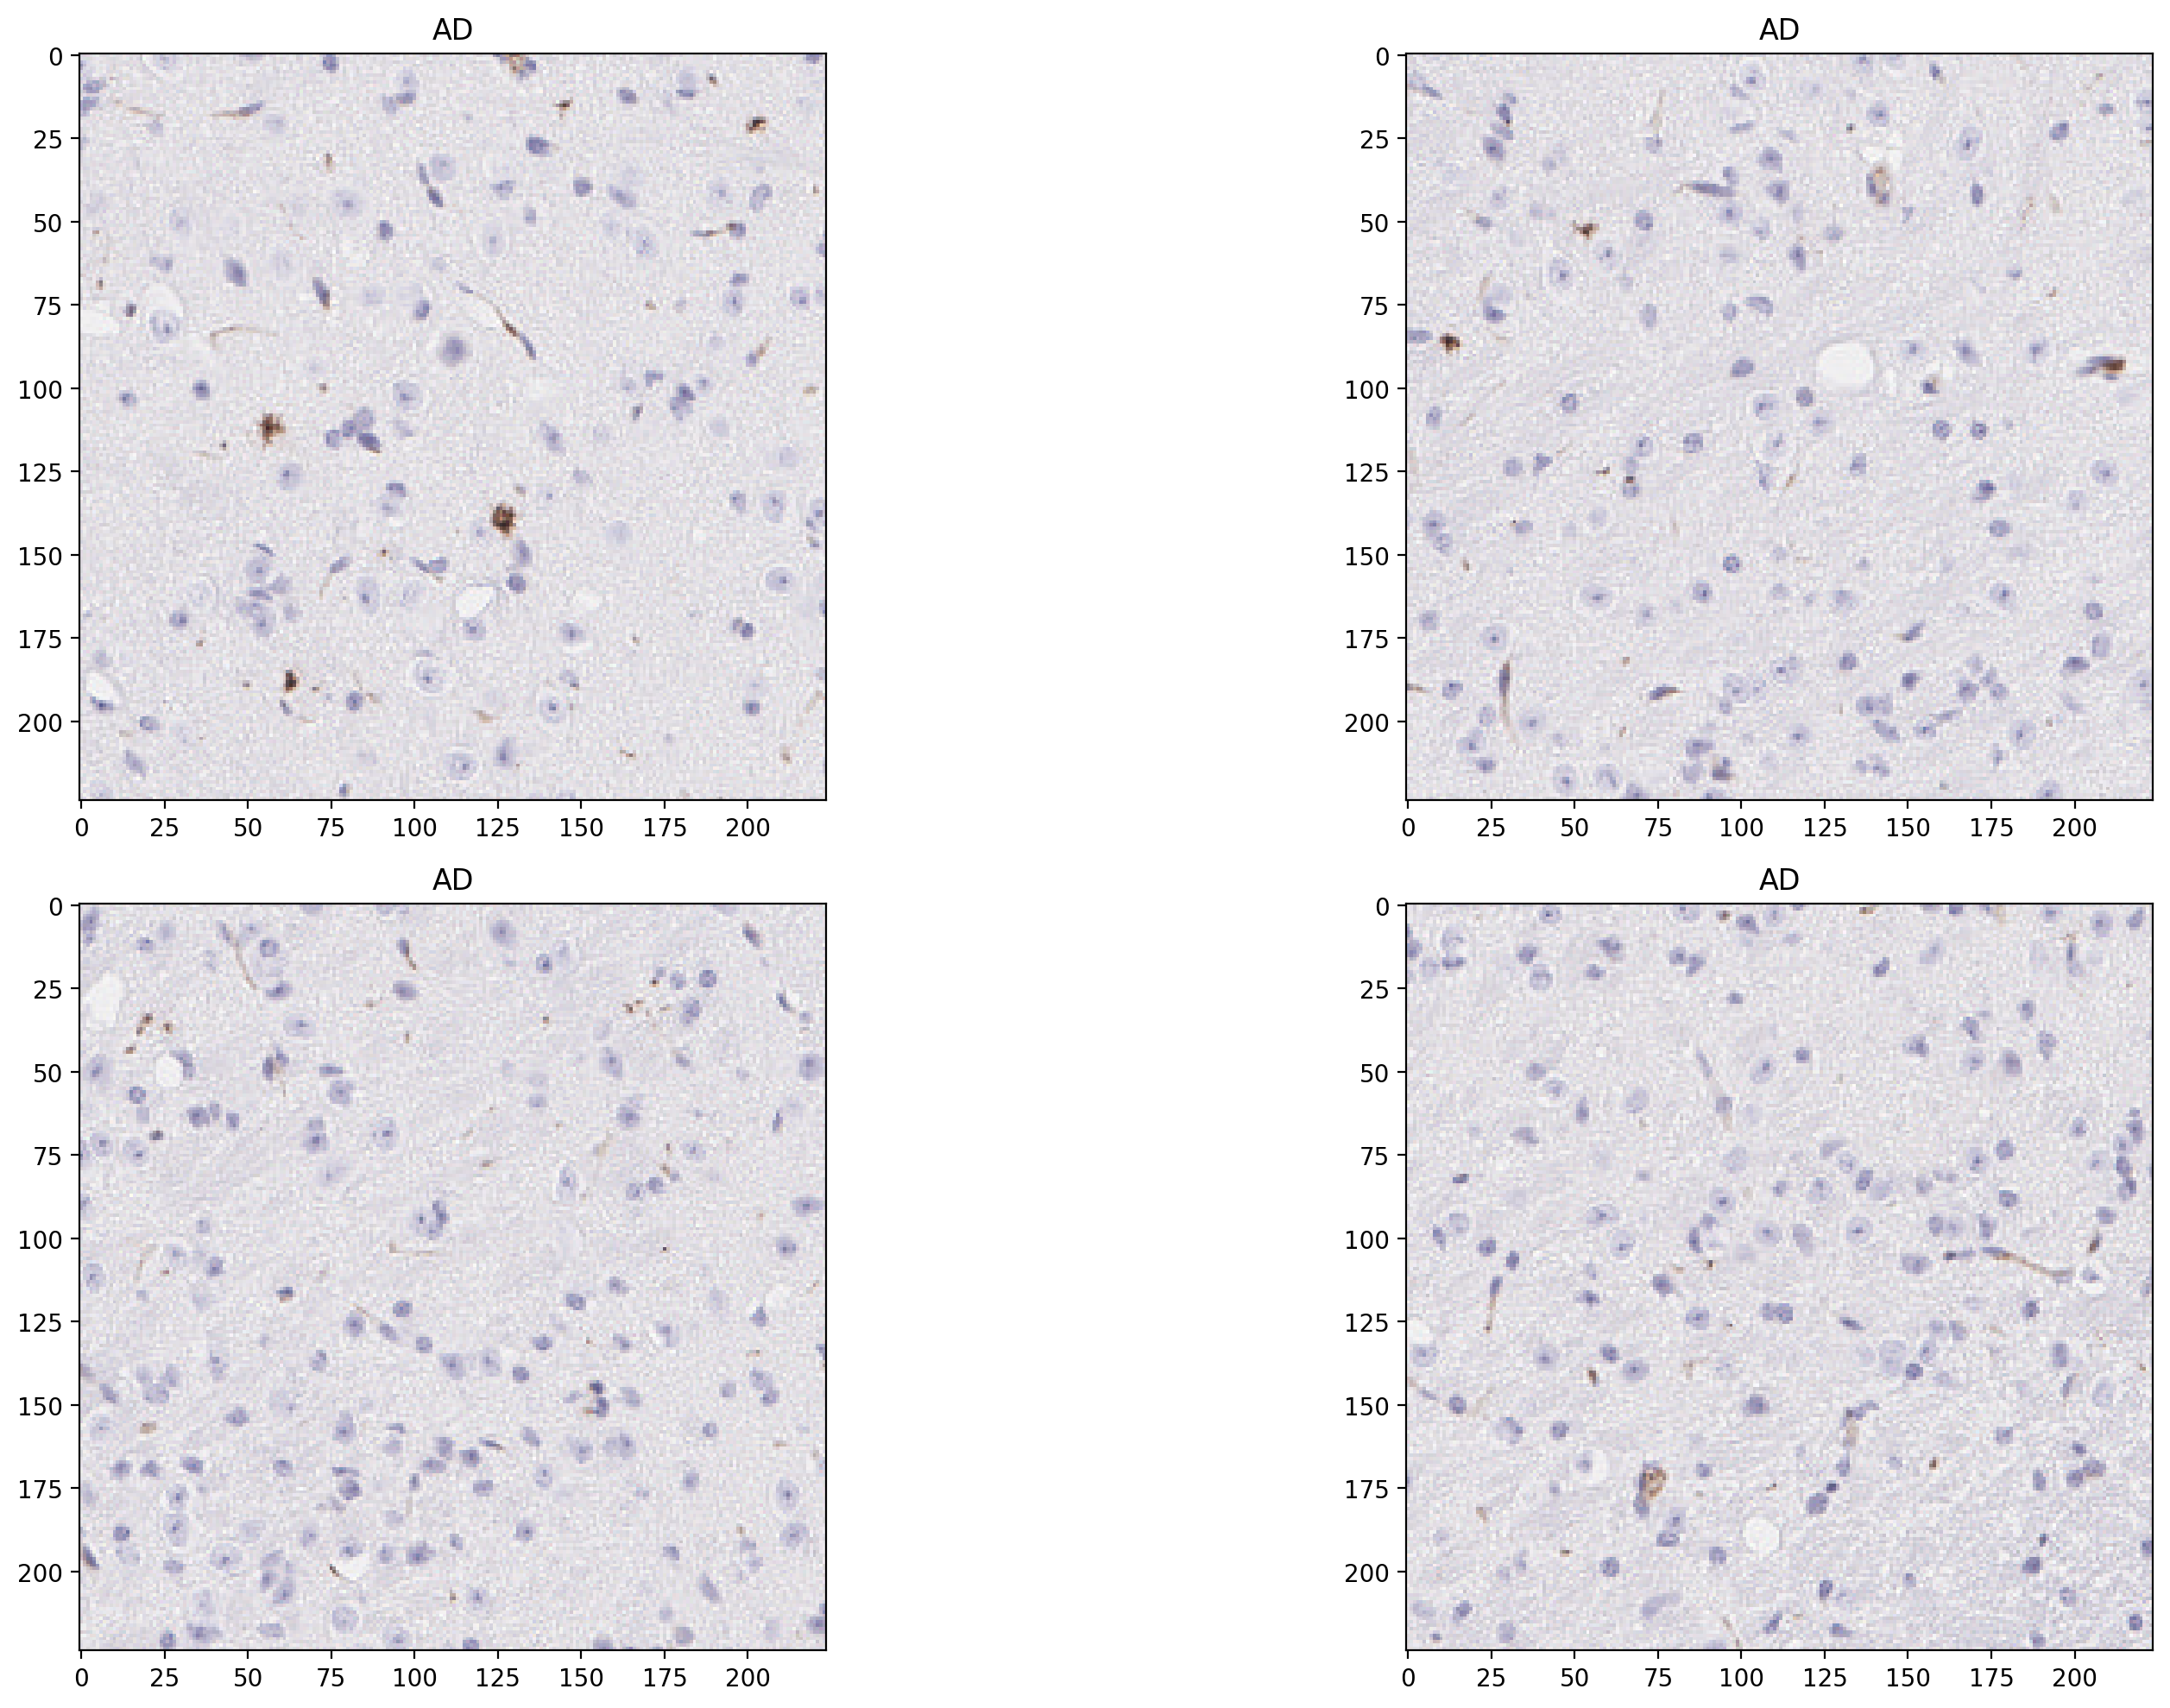

In [10]:
run_image(train_dataset_no_norm,l=2,w=2,start=2000)

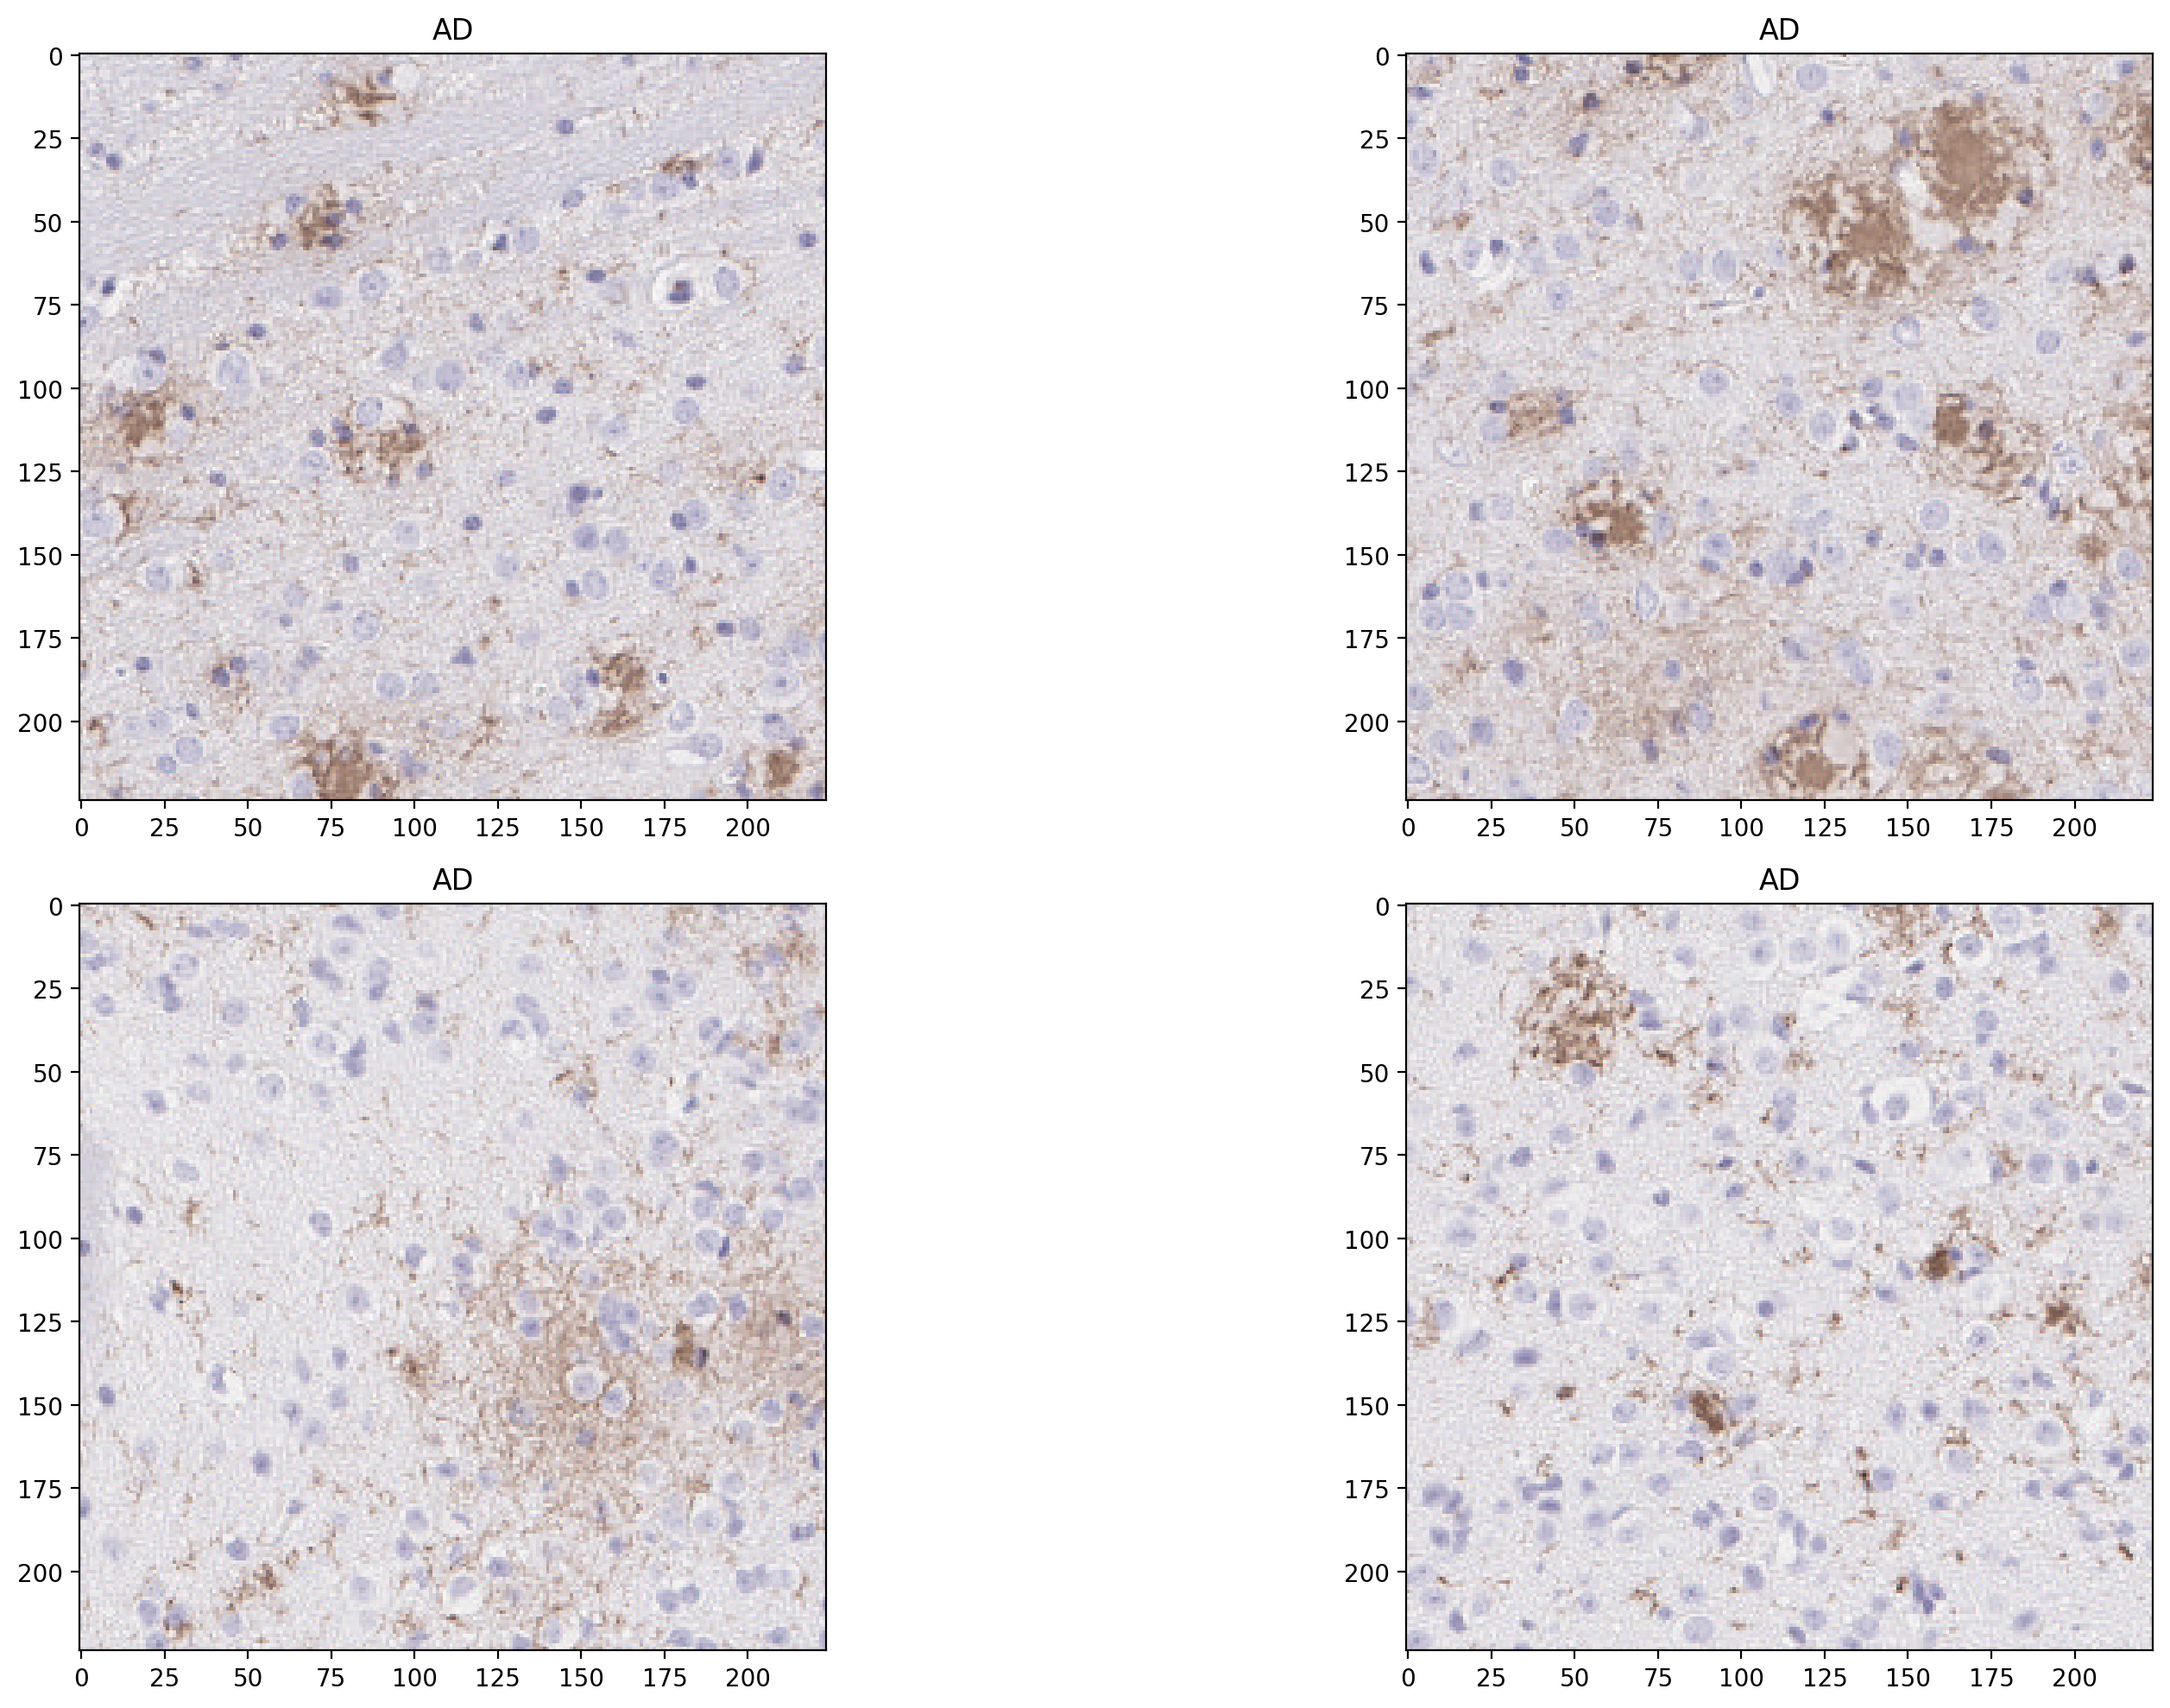

In [11]:
run_image(train_dataset_no_norm,l=2,w=2,start=3000)


<b>Control </b> data.  You see cells, but no plaque.

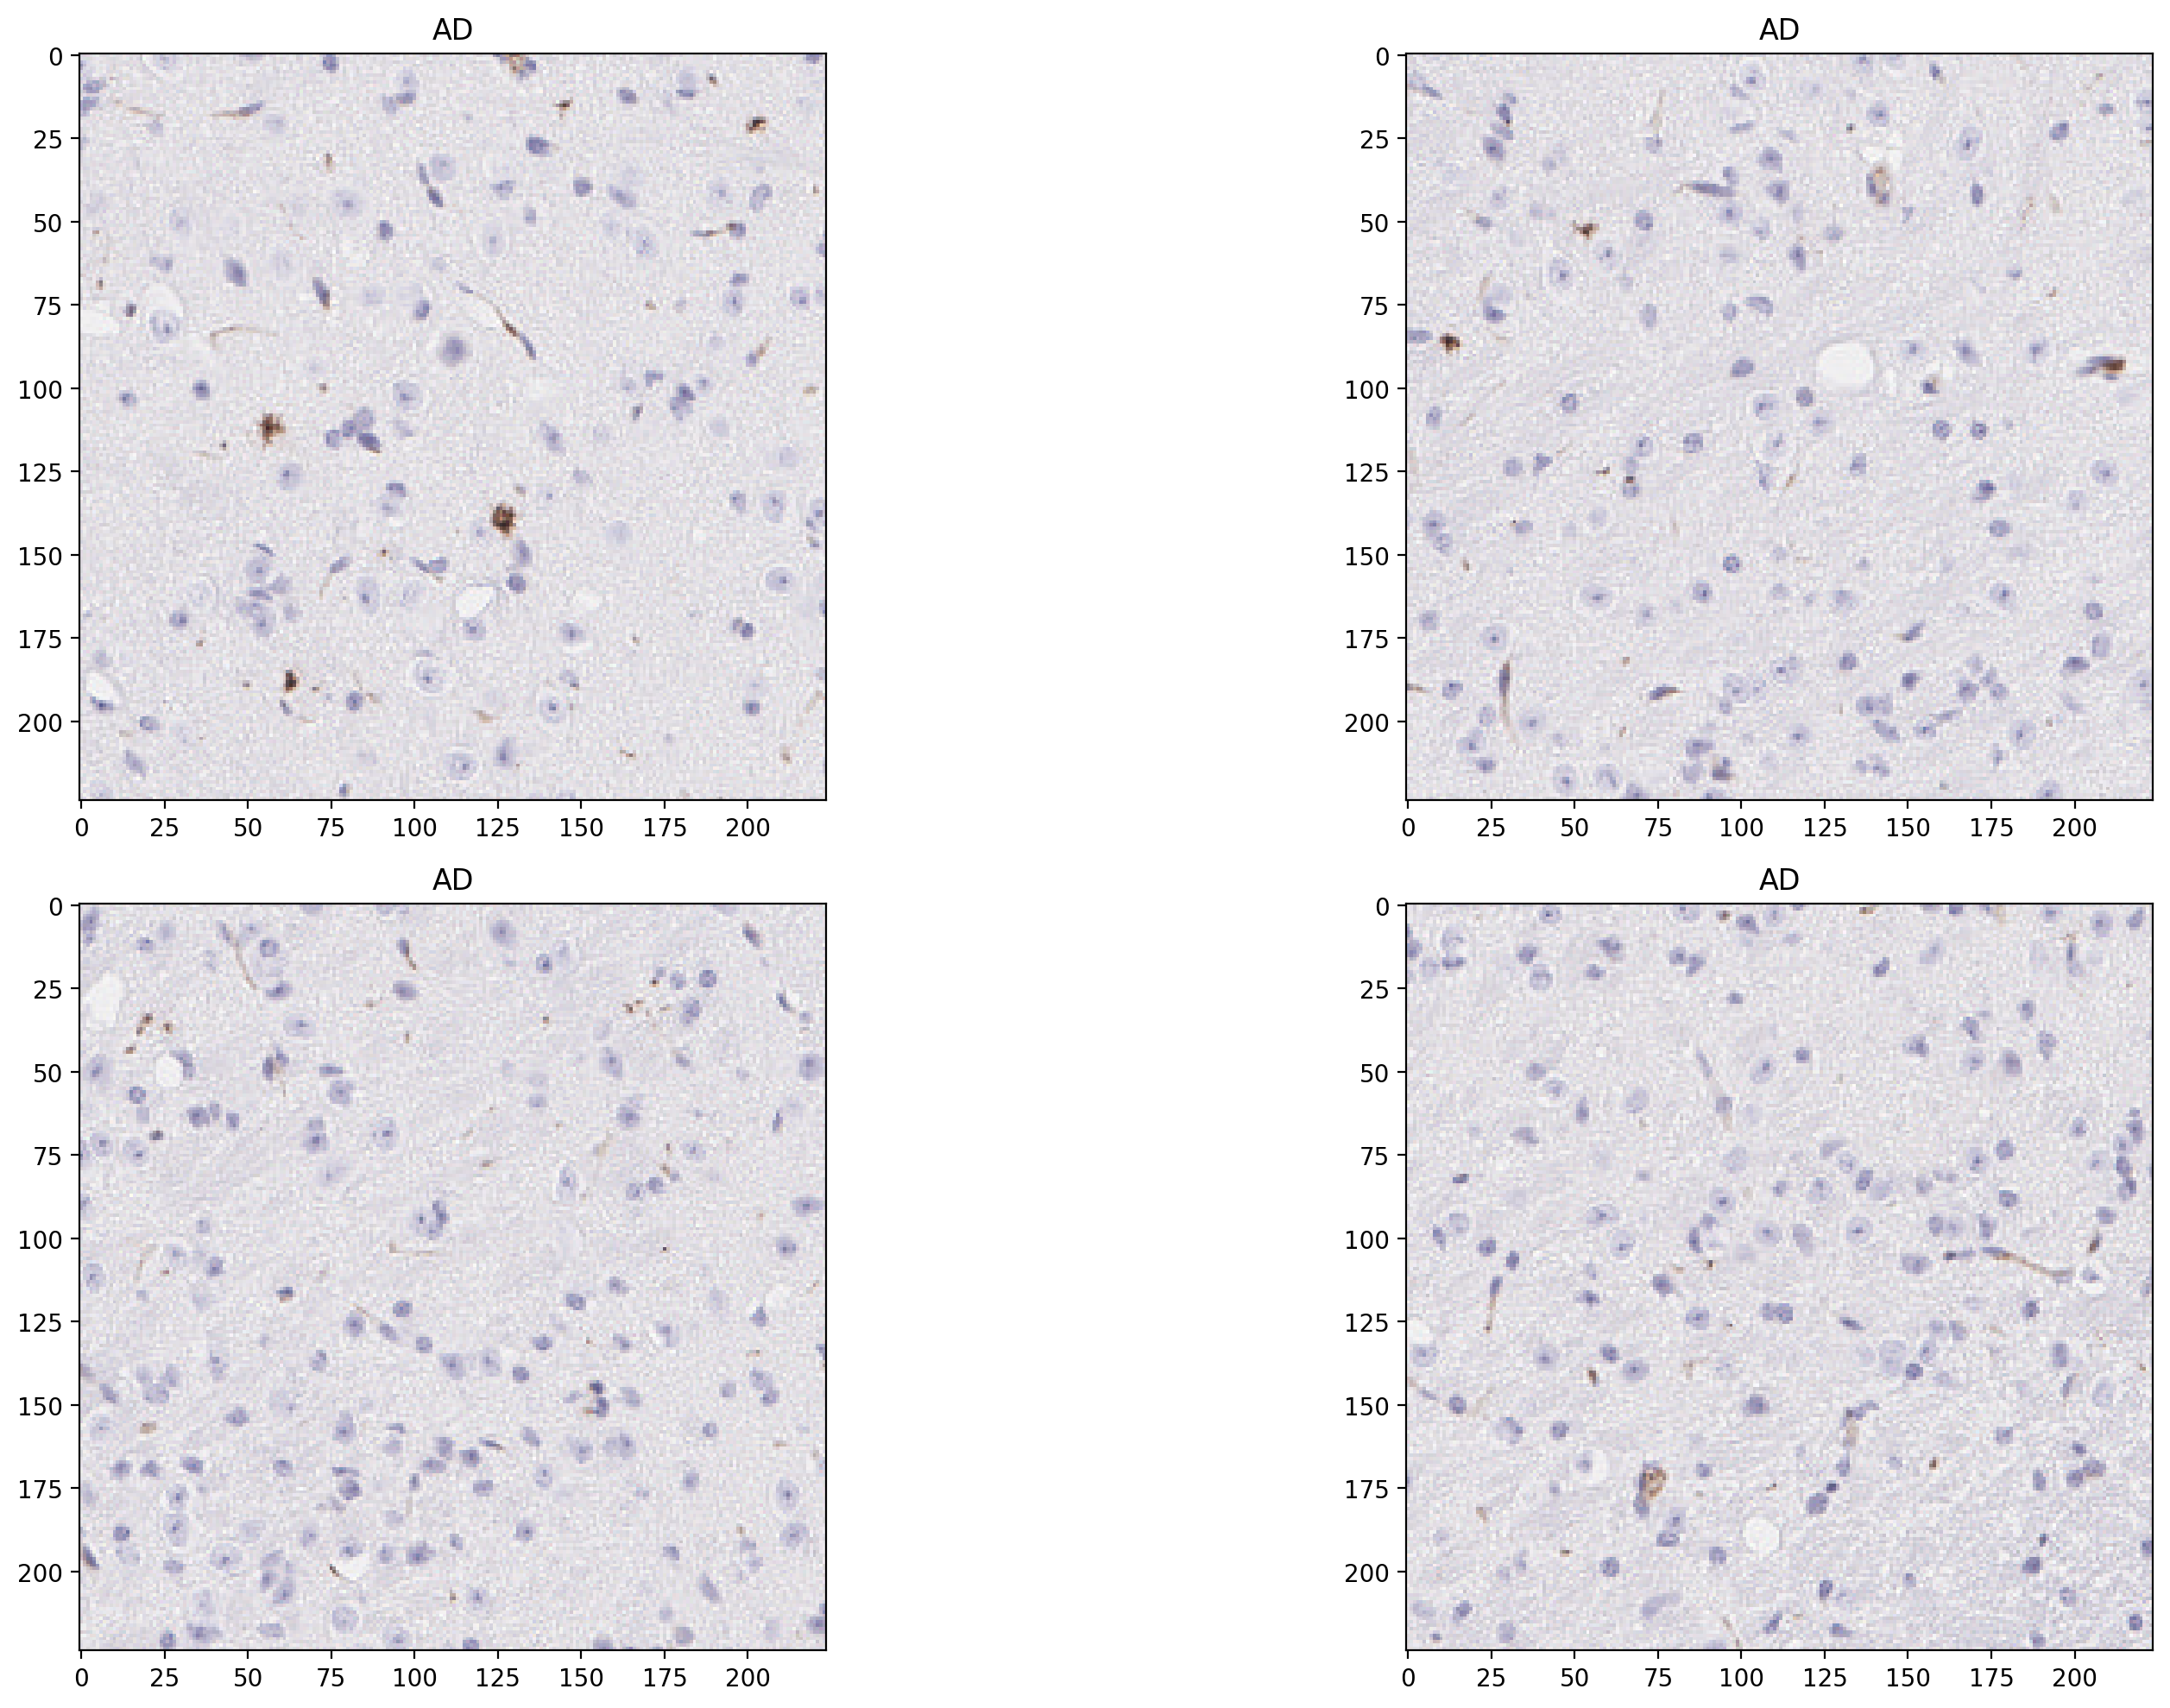

In [12]:
run_image(train_dataset_no_norm,l=2,w=2,start=2000)

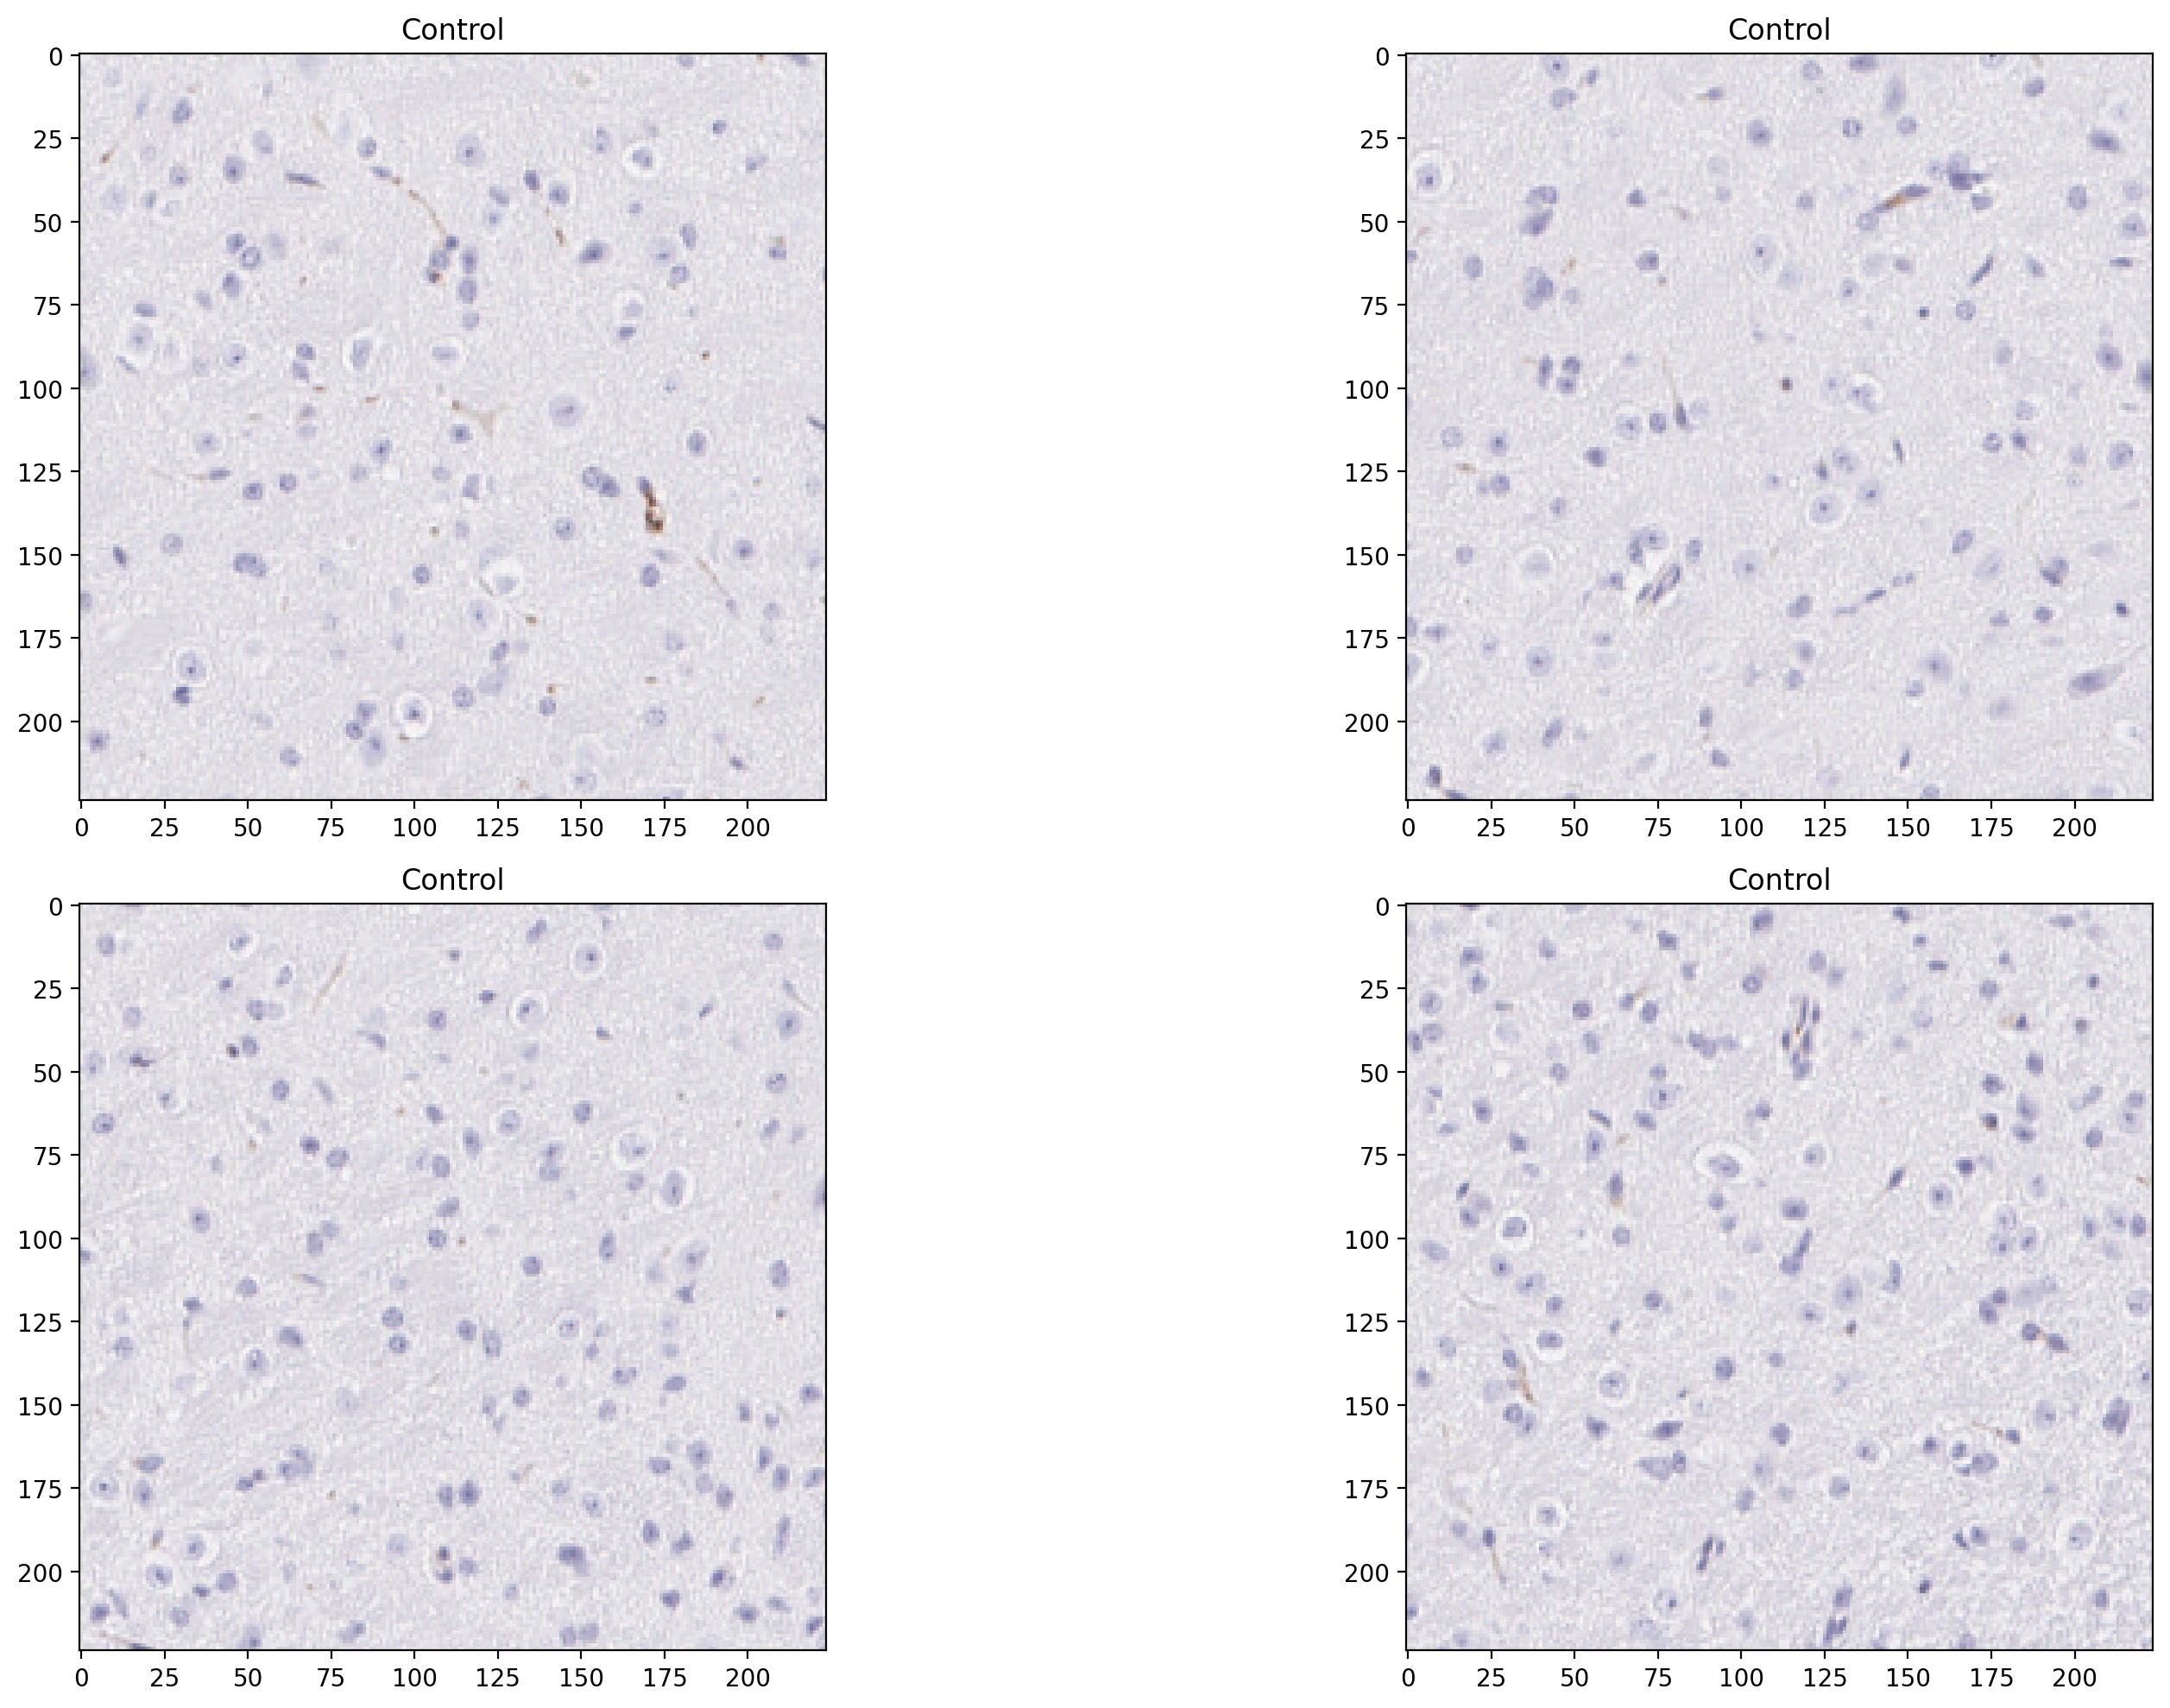

In [13]:
run_image(train_dataset_no_norm,l=2,w=2,start=4000)

Notice that some patches are just pure white background.
The code for creating model, loss, optimization and running forward and backpropagation is below.

In [14]:
model_resnet_v18=models.resnet18(weights="IMAGENET1K_V1")

In [15]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)
for param in model_resnet_v18.parameters():
    param.requires_grad=False
model_resnet_v18.fc=nn.Linear(512,1)
model_resnet_v18=model_resnet_v18.to(device)
criterion2=nn.BCEWithLogitsLoss()
optim2=optim.Adam(model_resnet_v18.parameters(),lr=1e-3,weight_decay=1e-5)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optim2, step_size=5, gamma=0.1)

cuda


In [16]:
loss_list=[]
loss_list_test=[]
test_accuracy_list=[]

for epoch in tqdm(range(20)):  # loop over the dataset multiple times
    model_resnet_v18.train()
    running_loss = 0.0
    total_samples=0
    for images, labels in train_data:
        # get the inputs; data is a list of [inputs, labels]
        images=images.to(device)
        labels=labels.float().to(device).view(-1,1)
        optim2.zero_grad()
        outputs = model_resnet_v18(images)
        #print(labels.shape,outputs.shape)
        preds=outputs
        loss = criterion2(outputs, labels)
        loss.backward()
        #print(model.conv1.weight.grad.norm())
        optim2.step()
        # print statistics
        running_loss += loss.item()*images.size(0)
        total_samples+=images.size(0)
    epoch_loss=running_loss/total_samples
    loss_list.append(epoch_loss)
    model_resnet_v18.eval()
    pred_list=[]
    actual_list=[]
    with torch.no_grad():
        test_running_loss=0.0
        total_samples_test=0
        for images,labels in test_data:
            images_test=images.to(device)
            labels_test=labels.float().to(device).view(-1,1)
            outputs_test=model_resnet_v18(images_test)
            preds=outputs_test
            pred_list.extend(preds.cpu().tolist())
            actual_list.extend(labels_test.cpu().tolist())
            new_loss=criterion2(preds,labels_test)
            test_running_loss+=new_loss.item()*images_test.size(0)
            total_samples_test+=images_test.size(0)
        total_loss_test=test_running_loss/total_samples_test
        loss_list_test.append(total_loss_test)
        pred_tensor=torch.tensor(pred_list)
        pred_probs=torch.sigmoid(pred_tensor)
        pred_class=(pred_probs>=0.5).int().numpy().flatten()
        actual_class=np.array(actual_list).astype(int).flatten()
        predictions_df=pd.DataFrame({"prediction":pred_class,"actual":actual_class})
        prediction=100*sum(predictions_df["prediction"]==predictions_df["actual"])/(predictions_df.shape[0])
        roc_score=roc_auc_score(predictions_df["actual"],predictions_df["prediction"])
        f1=f1_score(predictions_df["actual"],predictions_df["prediction"])

        test_accuracy_list.append(prediction)
    exp_lr_scheduler.step()

    print(f"Epoch: {epoch+1:02d}, Training Loss: {epoch_loss:.4f},Test Loss: {total_loss_test:.4f},Accuracy:{prediction:.2f} %,ROC Score: {roc_score:.2f},f1 Score {f1:.2f}")
print('Finished Training')

  5%|▌         | 1/20 [00:35<11:22, 35.92s/it]

Epoch: 01, Training Loss: 0.5025,Test Loss: 0.4287,Accuracy:81.56 %,ROC Score: 0.81,f1 Score 0.85


 10%|█         | 2/20 [01:12<10:57, 36.50s/it]

Epoch: 02, Training Loss: 0.3908,Test Loss: 0.3951,Accuracy:81.89 %,ROC Score: 0.82,f1 Score 0.83


 15%|█▌        | 3/20 [01:49<10:23, 36.69s/it]

Epoch: 03, Training Loss: 0.3843,Test Loss: 0.3743,Accuracy:82.95 %,ROC Score: 0.83,f1 Score 0.84


 20%|██        | 4/20 [02:26<09:44, 36.56s/it]

Epoch: 04, Training Loss: 0.3642,Test Loss: 0.3778,Accuracy:82.72 %,ROC Score: 0.83,f1 Score 0.84


 25%|██▌       | 5/20 [03:02<09:08, 36.57s/it]

Epoch: 05, Training Loss: 0.3539,Test Loss: 0.3646,Accuracy:83.44 %,ROC Score: 0.83,f1 Score 0.85


 30%|███       | 6/20 [03:39<08:31, 36.51s/it]

Epoch: 06, Training Loss: 0.3453,Test Loss: 0.3622,Accuracy:83.44 %,ROC Score: 0.83,f1 Score 0.85


 35%|███▌      | 7/20 [04:15<07:53, 36.42s/it]

Epoch: 07, Training Loss: 0.3461,Test Loss: 0.3614,Accuracy:83.83 %,ROC Score: 0.83,f1 Score 0.86


 40%|████      | 8/20 [04:51<07:17, 36.46s/it]

Epoch: 08, Training Loss: 0.3448,Test Loss: 0.3613,Accuracy:83.72 %,ROC Score: 0.83,f1 Score 0.85


 45%|████▌     | 9/20 [05:28<06:42, 36.62s/it]

Epoch: 09, Training Loss: 0.3444,Test Loss: 0.3620,Accuracy:84.05 %,ROC Score: 0.84,f1 Score 0.86


 50%|█████     | 10/20 [06:05<06:05, 36.58s/it]

Epoch: 10, Training Loss: 0.3438,Test Loss: 0.3619,Accuracy:84.27 %,ROC Score: 0.84,f1 Score 0.86


 55%|█████▌    | 11/20 [06:42<05:30, 36.72s/it]

Epoch: 11, Training Loss: 0.3440,Test Loss: 0.3602,Accuracy:83.61 %,ROC Score: 0.83,f1 Score 0.85


 60%|██████    | 12/20 [07:19<04:53, 36.71s/it]

Epoch: 12, Training Loss: 0.3447,Test Loss: 0.3633,Accuracy:84.05 %,ROC Score: 0.84,f1 Score 0.86


 65%|██████▌   | 13/20 [07:55<04:17, 36.72s/it]

Epoch: 13, Training Loss: 0.3436,Test Loss: 0.3619,Accuracy:83.89 %,ROC Score: 0.84,f1 Score 0.86


 70%|███████   | 14/20 [08:32<03:40, 36.68s/it]

Epoch: 14, Training Loss: 0.3439,Test Loss: 0.3606,Accuracy:83.67 %,ROC Score: 0.83,f1 Score 0.85


 75%|███████▌  | 15/20 [09:08<03:02, 36.60s/it]

Epoch: 15, Training Loss: 0.3409,Test Loss: 0.3617,Accuracy:84.11 %,ROC Score: 0.84,f1 Score 0.86


 80%|████████  | 16/20 [09:45<02:26, 36.57s/it]

Epoch: 16, Training Loss: 0.3423,Test Loss: 0.3640,Accuracy:83.67 %,ROC Score: 0.83,f1 Score 0.86


 85%|████████▌ | 17/20 [10:21<01:49, 36.38s/it]

Epoch: 17, Training Loss: 0.3433,Test Loss: 0.3615,Accuracy:83.94 %,ROC Score: 0.84,f1 Score 0.86


 90%|█████████ | 18/20 [10:58<01:13, 36.55s/it]

Epoch: 18, Training Loss: 0.3430,Test Loss: 0.3590,Accuracy:83.44 %,ROC Score: 0.83,f1 Score 0.85


 95%|█████████▌| 19/20 [11:32<00:35, 35.93s/it]

Epoch: 19, Training Loss: 0.3413,Test Loss: 0.3595,Accuracy:83.89 %,ROC Score: 0.84,f1 Score 0.86


100%|██████████| 20/20 [12:09<00:00, 36.46s/it]

Epoch: 20, Training Loss: 0.3434,Test Loss: 0.3646,Accuracy:83.94 %,ROC Score: 0.84,f1 Score 0.86
Finished Training


In [18]:
all_paths = [x[0] for x in train_dataset.imgs] + [x[0] for x in test_dataset.imgs]
concat_data=ConcatDataset([train_dataset,test_dataset])
concat_loader=DataLoader(concat_data,batch_size=128,shuffle=False)
model_resnet_v18.eval()
pred_list=[]
actual_list=[]
with torch.no_grad():
    full_running_loss=0.0
    total_samples_full=0
    for images,labels in concat_loader:
        images_full=images.to(device)
        labels_full=labels.float().to(device).view(-1,1)
        outputs_full=model_resnet_v18(images_full)
        preds=outputs_full
        pred_list.extend(preds.cpu().flatten().tolist())
        actual_list.extend(labels_full.flatten().cpu().tolist())
        new_loss=criterion2(preds,labels_full)
        full_running_loss+=new_loss.item()*images_full.size(0)
        total_samples_full+=images_full.size(0)
    total_loss_full=full_running_loss/total_samples_full
    pred_tensor=torch.tensor(pred_list)
    pred_probs=torch.sigmoid(pred_tensor)
    pred_class=(pred_probs>=0.5).int().numpy().flatten()
    actual_class=np.array(actual_list).astype(int).flatten()
    predictions_df=pd.DataFrame({"prediction":pred_class,"actual":actual_class,"sample_path":all_paths,
                                "pred_activation":pred_list,"pred_prob":pred_probs.numpy().flatten()})
    prediction=100*sum(predictions_df["prediction"]==predictions_df["actual"])/(predictions_df.shape[0])
    roc_score=roc_auc_score(predictions_df["actual"],predictions_df["prediction"])
    f1=f1_score(predictions_df["actual"],predictions_df["prediction"])

In [19]:
predictions_df.shape

(7456, 5)

In [20]:
predictions_df.head()

prediction  actual                                        sample_path  \
0           0       0  /data/banskotan2/Projects/Deep_Learning/5XFAD/...   
1           0       0  /data/banskotan2/Projects/Deep_Learning/5XFAD/...   
2           0       0  /data/banskotan2/Projects/Deep_Learning/5XFAD/...   
3           0       0  /data/banskotan2/Projects/Deep_Learning/5XFAD/...   
4           0       0  /data/banskotan2/Projects/Deep_Learning/5XFAD/...   

   pred_activation  pred_prob  
0        -5.665872   0.003450  
1        -5.199922   0.005487  
2        -6.033973   0.002390  
3        -6.689977   0.001242  
4        -1.449210   0.190123

In [21]:
predictions_df["new_path"]=predictions_df["sample_path"].str.replace(r"(.*abeta)_.*", r"\1.png",regex=True)

In [22]:
predictions_df["new_path"]=predictions_df["new_path"].str.replace(r".*\/",r"",regex=True)

In [23]:
predictions_df["sample_path"][500]

'/data/banskotan2/Projects/Deep_Learning/5XFAD/patches/Train/AD/64911pi2.2-100224-13-30039-br-abeta_x6871_y4557_level1.png'

In [24]:
predictions_df["new_path"][500]

'64911pi2.2-100224-13-30039-br-abeta.png'

In [25]:
metadata=pd.read_csv("image_info.csv")

In [26]:
metadata["new_path"]=metadata["filename"].str.replace(r".*\/",r"",regex=True)

In [27]:
final_merged=pd.merge(predictions_df,metadata,how="inner",on="new_path")

In [28]:
final_merged.columns

Index(['prediction', 'actual', 'sample_path', 'pred_activation', 'pred_prob',
       'new_path', 'Unnamed: 0', 'Notes', 'ID', 'Tag', 'Sex', 'Strain', 'Born',
       'ASP', 'Location', 'Sire', 'Dam', 'Vendor', 'PlateCount',
       'MostRecentPlate', 'GeneTranslation', 'Gene1', 'Gtype', 'Gene2',
       'Gtype.1', 'Gene3', 'Gtype.2', 'Gene4', 'Gtype.3', 'LastAccess',
       'ModifiedBy', 'AgeMo', 'AgeW', 'cagesize', 'Cage', 'DVC cage code',
       'Plans', 'Behavior testing code', 'filename', 'AgeCateg'],
      dtype='object')

In [29]:
final_merged2=final_merged[["prediction","pred_activation","pred_prob","actual","new_path","Gtype.1","AgeCateg"]].copy()

In [30]:
final_merged2.head()

prediction  pred_activation  pred_prob  actual  \
0           0        -5.665872   0.003450       0   
1           0        -5.199922   0.005487       0   
2           0        -6.033973   0.002390       0   
3           0        -6.689977   0.001242       0   
4           0        -1.449210   0.190123       0   

                                  new_path Gtype.1 AgeCateg  
0  64911pi2.2-100224-10-30031-br-abeta.png       +        B  
1  64911pi2.2-100224-10-30031-br-abeta.png       +        B  
2  64911pi2.2-100224-10-30031-br-abeta.png       +        B  
3  64911pi2.2-100224-10-30031-br-abeta.png       +        B  
4  64911pi2.2-100224-10-30031-br-abeta.png       +        B

In [31]:
final_merged2["prediction"]=1-final_merged2["prediction"]

In [32]:
final_merged2_grouped=final_merged2.groupby(["new_path","Gtype.1","AgeCateg"]).agg({"pred_activation":"mean","prediction":"mean","pred_prob":"mean"})

In [33]:
final_merged2_grouped.head()

pred_activation  \
new_path                                Gtype.1 AgeCateg                    
64911pi2.2-100224-1-29966-br-abeta.png  +       A               -4.374432   
64911pi2.2-100224-10-30031-br-abeta.png +       B               -3.333610   
64911pi2.2-100224-11-30037-br-abeta.png +       B               -2.497873   
64911pi2.2-100224-12-30038-br-abeta.png -       B                1.627987   
64911pi2.2-100224-13-30039-br-abeta.png +       B               -2.296869   

                                                          prediction  \
new_path                                Gtype.1 AgeCateg               
64911pi2.2-100224-1-29966-br-abeta.png  +       A           0.967033   
64911pi2.2-100224-10-30031-br-abeta.png +       B           0.887755   
64911pi2.2-100224-11-30037-br-abeta.png +       B           0.828671   
64911pi2.2-100224-12-30038-br-abeta.png -       B           0.062112   
64911pi2.2-100224-13-30039-br-abeta.png +       B           0.773292   

                                                          pred_prob  
new_path                                Gtype.1 AgeCateg             
64911pi2.2-100224-1-29966-br-abeta.png  +       A          0.054264  
64911pi2.2-100224-10-30031-br-abeta.png +       B          0.136375  
64911pi2.2-100224-11-30037-br-abeta.png +       B          0.202972  
64911pi2.2-100224-12-30038-br-abeta.png -       B          0.800703  
64911pi2.2-100224-13-30039-br-abeta.png +       B          0.235370

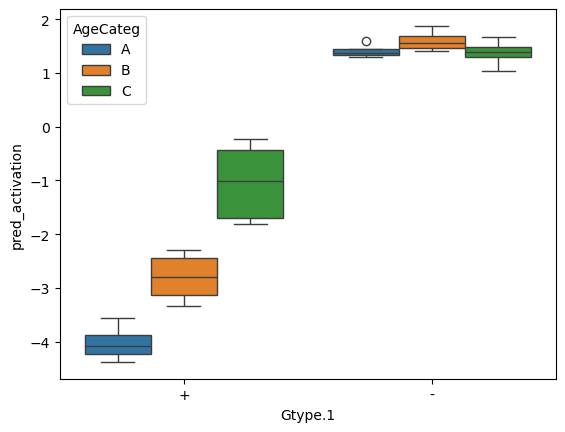

In [34]:
sns.boxplot(data=final_merged2_grouped,x="Gtype.1",y="pred_activation",hue="AgeCateg")
plt.show()

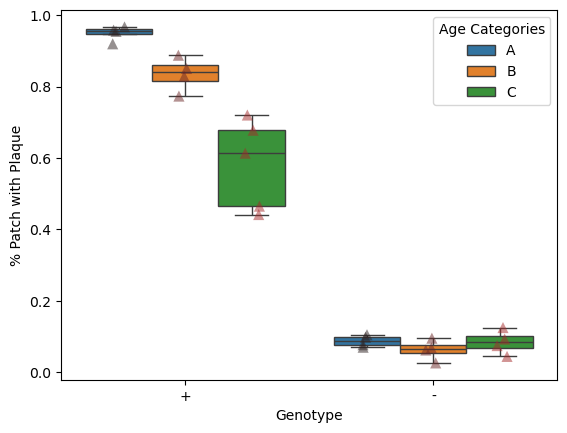

In [72]:
plot_patch=sns.boxplot(data=final_merged2_grouped,x="Gtype.1",y="prediction",hue="AgeCateg",fliersize=0)
sns.stripplot(data=final_merged2_grouped, x="Gtype.1", y="prediction", dodge=True,hue="AgeCateg",
              palette="dark:brown",
               jitter=True,marker='^',alpha=0.5,legend=False,ax=plot_patch,size=8)
plt.ylabel("% Patch with Plaque")
plt.xlabel("Genotype")
plt.legend(title="Age Categories")
fig=plot_patch.get_figure()
plt.savefig("Percent_patches_with_plaque.pdf")
plt.show()

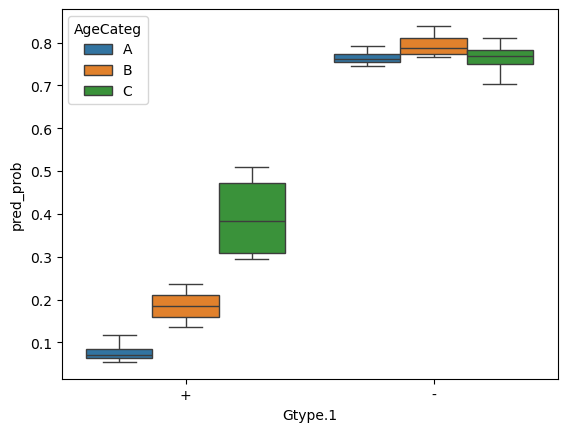

In [36]:
sns.boxplot(data=final_merged2_grouped,x="Gtype.1",y="pred_prob",hue="AgeCateg")
plt.show()

In [61]:
 print(sns.__version__) 

0.13.2
